# Trees

In [255]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, export_text, export_graphviz
from sklearn.feature_extraction import DictVectorizer
from sklearn.metrics import roc_auc_score
import seaborn as sns

In [209]:
df = pd.read_csv('CreditScoring.csv')

In [210]:
df.head()

,Status,Seniority,Home,Time,Age,Marital,Records,Job,Expenses,Income,Assets,Debt,Amount,Price
0,1,9,1,60,30,2,1,3,73,129,0,0,800,846
1,1,17,1,60,58,3,1,1,48,131,0,0,1000,1658
2,2,10,2,36,46,2,2,3,90,200,3000,0,2000,2985
3,1,0,1,60,24,1,1,1,63,182,2500,0,900,1325
4,1,0,1,36,26,1,1,1,46,107,0,0,310,910


## Data Cleaning

In [211]:
def standardise_colnames(df: pd.DataFrame) -> pd.DataFrame:
  df = df.copy()
  df.columns = df.columns.str.lower().str.replace(' ', '_')
  return df

In [212]:
df = standardise_colnames(df)

In [213]:
df.head()

,status,seniority,home,time,age,marital,records,job,expenses,income,assets,debt,amount,price
0,1,9,1,60,30,2,1,3,73,129,0,0,800,846
1,1,17,1,60,58,3,1,1,48,131,0,0,1000,1658
2,2,10,2,36,46,2,2,3,90,200,3000,0,2000,2985
3,1,0,1,60,24,1,1,1,63,182,2500,0,900,1325
4,1,0,1,36,26,1,1,1,46,107,0,0,310,910


In [214]:
status_values = {
  0: 'unk',
  1: 'ok',
  2: 'default'
}
df.status = df.status.map(status_values)

In [215]:
home_values = {
  0: 'unk',
  1: 'rent',
  2: 'owner',
  3: 'private',
  4: 'ignore',
  5: 'parents',
  6: 'other'
}
df.home = df.home.map(home_values)

In [216]:
marital_values = {
  0: 'unk',
  1: 'single',
  2: 'married',
  3: 'widow',
  4: 'separated',
  5: 'divorced'
}
df.marital = df.marital.map(marital_values)

In [217]:
records_values = {
  0: 'unk',
  1: 'no',
  2: 'yes'
}
df.records = df.records.map(records_values)

In [218]:
job_values = {
  0: 'unk',
  1: 'fixed',
  2: 'partime',
  3: 'freelance',
  4: 'others'
}
df.job = df.job.map(job_values)

In [219]:
df.describe().round()

,seniority,time,age,expenses,income,assets,debt,amount,price
count,4455.0,4455.0,4455.0,4455.0,4455.0,4455.0,4455.0,4455.0,4455.0
mean,8.0,46.0,37.0,56.0,763317.0,1060341.0,404382.0,1039.0,1463.0
std,8.0,15.0,11.0,20.0,8703625.0,10217569.0,6344253.0,475.0,628.0
min,0.0,6.0,18.0,35.0,0.0,0.0,0.0,100.0,105.0
25%,2.0,36.0,28.0,35.0,80.0,0.0,0.0,700.0,1118.0
50%,5.0,48.0,36.0,51.0,120.0,3500.0,0.0,1000.0,1400.0
75%,12.0,60.0,45.0,72.0,166.0,6000.0,0.0,1300.0,1692.0
max,48.0,72.0,68.0,180.0,99999999.0,99999999.0,99999999.0,5000.0,11140.0


In [220]:
df.income = df.income.replace(df.income.max(), np.nan)
df.assets = df.assets.replace(df.assets.max(), np.nan)
df.debt = df.debt.replace(df.debt.max(), np.nan)

In [221]:
df = df.loc[df.status != 'unk'].reset_index(drop=True)

## Validation Framework

In [222]:
df_train_full, df_test = train_test_split(df, test_size=.2, random_state=11)
df_train, df_val = train_test_split(df_train_full, test_size=.25, random_state=11)

In [223]:
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

In [224]:
y_train = (df_train.status == 'default').astype(int).values
y_val = (df_val.status == 'default').astype(int).values
y_test = (df_test.status == 'default').astype(int).values

In [225]:
df_train.drop('status', axis=1, inplace=True, errors='ignore')
df_val.drop('status', axis=1, inplace=True, errors='ignore')
df_test.drop('status', axis=1, inplace=True, errors='ignore')

In [226]:
df_train.head()

,seniority,home,time,age,marital,records,job,expenses,income,assets,debt,amount,price
0,10,owner,36,36,married,no,freelance,75,0.0,10000.0,0.0,1000,1400
1,6,parents,48,32,single,yes,fixed,35,85.0,0.0,0.0,1100,1330
2,1,parents,48,40,married,no,fixed,75,121.0,0.0,0.0,1320,1600
3,1,parents,48,23,single,no,partime,35,72.0,0.0,0.0,1078,1079
4,5,owner,36,46,married,no,freelance,60,100.0,4000.0,0.0,1100,1897


## Feature Preparation

In [227]:
def encode_vars(df: pd.DataFrame, dv: DictVectorizer = None):
  df_dicts = df.fillna(0).to_dict(orient='records')

  if not dv:
    dv = DictVectorizer(sparse=False)
    dv.fit(df_dicts)
  
  encoded_data = dv.transform(df_dicts)

  return encoded_data, dv

In [228]:
X_train, dv = encode_vars(df_train)
X_val, _ = encode_vars(df_val, dv)
X_test, _ = encode_vars(df_test, dv)

In [229]:
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

(2672, 29)
(891, 29)
(891, 29)


## Decision Trees
A decision tree is a data structure with a root node with branches leading to child nodes. Each node represents a binary decision point in the model where incoming data points are classified and passed along the corresponding branch.

In [230]:
dt = DecisionTreeClassifier()
dt.fit(X_train, y_train)

DecisionTreeClassifier()

In [231]:
y_pred = dt.predict_proba(X_val)[:, 1]

In [232]:
roc_auc_score(y_val, y_pred)

0.650062967716936

In [233]:
y_pred = dt.predict_proba(X_train)[:, 1]

In [234]:
roc_auc_score(y_train, y_pred)

1.0

The decision tree is overfitted because it has unrestricted depth, and can create infinite classification rules.

In [235]:
dt = DecisionTreeClassifier(max_depth=3)
dt.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=3)

In [236]:
y_pred = dt.predict_proba(X_val)[:, 1]
roc_auc_score(y_val, y_pred)

0.7389079944782155

In [237]:
y_pred = dt.predict_proba(X_train)[:, 1]
roc_auc_score(y_train, y_pred)

0.7761016984958594

We achieve better validation performance by restricting the tree depth.

In [242]:
print(export_text(dt, feature_names=dv.feature_names_))

|--- records=no <= 0.50
|   |--- seniority <= 6.50
|   |   |--- amount <= 862.50
|   |   |   |--- class: 0
|   |   |--- amount >  862.50
|   |   |   |--- class: 1
|   |--- seniority >  6.50
|   |   |--- income <= 103.50
|   |   |   |--- class: 1
|   |   |--- income >  103.50
|   |   |   |--- class: 0
|--- records=no >  0.50
|   |--- job=partime <= 0.50
|   |   |--- income <= 74.50
|   |   |   |--- class: 0
|   |   |--- income >  74.50
|   |   |   |--- class: 0
|   |--- job=partime >  0.50
|   |   |--- assets <= 8750.00
|   |   |   |--- class: 1
|   |   |--- assets >  8750.00
|   |   |   |--- class: 0



## Decision Tree Learning Algorithm
- Every node has a condition that takes the form of a feature and a threshold value.
- Datapoints are split based on this threshold value.
- Optimal splitting thresholds are identified by evaluating the missclassification rate for different threshold values
- find the lowest impurity split across features to find the next feature to add to the tree
- stopping criteria: pure group (0% impurity), max depth, min group size

## Parameter Tuning
max_depth, min_samples_leaf

In [247]:
for d in [1, 2, 3, 4, 5, 6, 10, 15, 20, None]:
  dt = DecisionTreeClassifier(max_depth=d)
  dt.fit(X_train, y_train)

  y_pred = dt.predict_proba(X_val)[:, 1]
  auc = roc_auc_score(y_val, y_pred)

  print(f'Depth: {d} -> {auc:.3f}')

Depth: 1 -> 0.606
Depth: 2 -> 0.669
Depth: 3 -> 0.739
Depth: 4 -> 0.761
Depth: 5 -> 0.767
Depth: 6 -> 0.744
Depth: 10 -> 0.701
Depth: 15 -> 0.666
Depth: 20 -> 0.669
Depth: None -> 0.661


In [249]:
scores = []

for d in [4, 5, 6]:
  for s in [1, 2, 5, 10, 15, 20, 100, 200, 500]:
    dt = DecisionTreeClassifier(max_depth=d, min_samples_leaf=s)
    dt.fit(X_train, y_train)

    y_pred = dt.predict_proba(X_val)[:, 1]
    auc = roc_auc_score(y_val, y_pred)
    scores.append((d, s, auc))
    # print(f'(Depth: {d}, Min Samples Leaf: {s}) -> {auc:.3f}')

In [250]:
df_scores = pd.DataFrame(scores, columns=['max_depth', 'min_samples_leaf', 'auc'])

In [253]:
df_scores_pivot = df_scores.pivot(index='min_samples_leaf', columns=['max_depth'], values=['auc'])

In [254]:
df_scores_pivot.round(3)

auc              
max_depth             4      5      6
min_samples_leaf                     
1                 0.761  0.766  0.760
2                 0.761  0.767  0.754
5                 0.761  0.768  0.761
10                0.761  0.762  0.778
15                0.764  0.772  0.785
20                0.761  0.774  0.774
100               0.756  0.763  0.776
200               0.747  0.759  0.768
500               0.680  0.680  0.680

<Axes: xlabel='None-max_depth', ylabel='min_samples_leaf'>

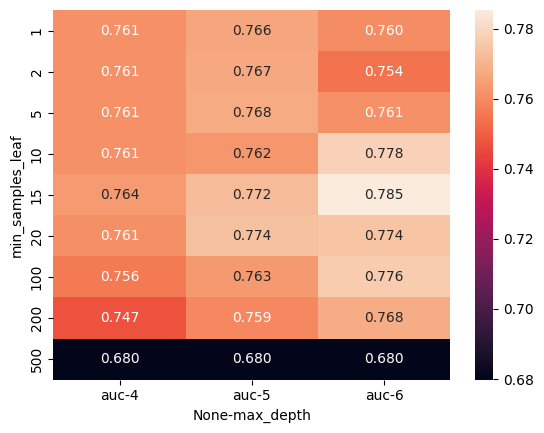

In [257]:
sns.heatmap(df_scores_pivot, annot=True, fmt='.3f')